In [123]:
import pandas as pd
import requests
import json
import datetime as dt
import os
import plotly as plt
import tensorflow as tf
import keras
import numpy as np
import pyod
from pyod.models.ecod import ECOD
import time
import plotly.express as px

# Diagram of Actions <br>
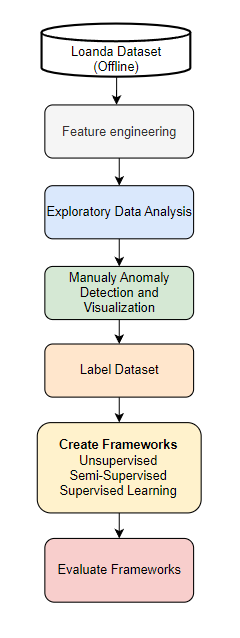

# Loanda Dataset <br>
Real Dataset from Loanda, Paraná, Brazil.

Os dados estão na pasta data/loandas/generation_data. Os dados foram particionados em json.

In [124]:
json_file_path = 'C:/Users/EMC/Documents/doutorado/doctorade/data/loanda/generation_data/'

os.listdir(json_file_path)

['loanda_data_curated_0.json',
 'loanda_data_curated_200000.json',
 'loanda_data_curated_400000.json',
 'loanda_data_curated_600000.json',
 'loanda_data_curated_800000.json']

# Weather Data<br>
https://open-meteo.com/en/docs/historical-weather-api#start_date=2021-07-01&end_date=2023-10-17&hourly=temperature_2m,relativehumidity_2m,precipitation,weathercode,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,terrestrial_radiation_instant&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&timezone=America%2FSao_Paulo

In [125]:
json_file_path = 'C:/Users/EMC/Documents/doutorado/doctorade/data/loanda/weather_data/'

os.listdir(json_file_path)

['loanda_weather.json', 'loanda_weather_curated.json']

# Load Data

In [126]:
# Weather Data
path = 'C:/Users/EMC/Documents/doutorado/doctorade/data/loanda/weather_data/loanda_weather_curated.json'
with open(path, "r") as json_file:
# Load the JSON data into a Python object.
    json_data = json.load(json_file)
    df_weather = pd.DataFrame.from_dict(json_data)

df_weather = df_weather[['time_in_iso8601','is_day_in_']].sort_values(by='time_in_iso8601')

df_weather[['time_in_iso8601','is_day_in_']].sort_values(by='time_in_iso8601')

# Loanda Data
json_file_path = 'C:/Users/EMC/Documents/doutorado/doctorade/data/loanda/generation_data/'
df_generation = pd.DataFrame()
for data_chunks in os.listdir(json_file_path):
    path = json_file_path + data_chunks
    with open(path, "r") as json_file:
    # Load the JSON data into a Python object.
        json_data = json.load(json_file)
        pd_json_data = pd.DataFrame.from_dict(json_data)
        df_generation = pd.concat([df_generation,pd_json_data])

df = df_generation
# Find None
df = df.replace('nan', None)
# To Datetime
df['E3TimeStamp'] = pd.to_datetime(df['E3TimeStamp'], format = 'mixed')

df_time = df[['E3TimeStamp']]

df_float = df[['PotenciaAtivaTotal', 'EnergiaTotal_DataLogger',
       'EnergiaDiaria_DataLogger', 'RadiacaoGlobal', 'TempAr', 'TempModulo',
       'VelocidadeVento', 'EnergiaTotal_LoteB', 'EnergiaDiaria_LoteB',
       'EnergiaReativa_LoteB', 'EnergiaTotal_LoteC', 'EnergiaDiaria_LoteC',
       'EnergiaReativa_LoteC', 'EnergiaTotal_LoteD', 'EnergiaDiaria_LoteD',
       'EnergiaReativa_LoteD', 'EnergiaTotal_LoteE', 'EnergiaDiaria_LoteE',
       'EnergiaReativa_LoteE', 'EnergiaTotal_LoteF', 'EnergiaDiaria_LoteF',
       'EnergiaReativa_LoteF']].astype(float)

df = pd.concat([df_time,df_float], axis = 1)

df = df.sort_values(by='E3TimeStamp')

# Exploratory Data Analysis I

## Generation Data

In [127]:
try:
  df = df.set_index('E3TimeStamp')
except:
  pass
try:
  del df['YMDH']
except:
  pass
try:
  del df['is_day_in_']
except:
  pass


df_descricao = pd.DataFrame()

df_descricao['No_None_Values_Count'] = round(df.apply(lambda x: x.count()),2)
df_descricao['None_Values_Count'] = round(df.apply(lambda x: x.isnull().sum()),2)
df_descricao['Zeroes_Values_Count'] = round(df.apply(lambda x: (x == 0).sum()),2)
df_descricao['Min_Values'] = round(df.apply(lambda x: x.min()),2)
df_descricao['Max_Values'] = round(df.apply(lambda x: x.max()),2)
df_descricao['Mean_Values'] = round(df.apply(lambda x: x.mean()),2)
df_descricao['Std_Values'] = round(df.apply(lambda x: x.std()),2)
df_descricao['Sum of Values'] = round(df.apply(lambda x: x.sum()),0)
df_descricao['Min_Date'] = df.index.min()
df_descricao['Max_Date'] = df.index.max()
df_descricao

,No_None_Values_Count,None_Values_Count,Zeroes_Values_Count,Min_Values,Max_Values,Mean_Values,Std_Values,Sum of Values,Min_Date,Max_Date
PotenciaAtivaTotal,949873,0,480295,0.00,5040.00,1026.97,1565.13,9.754909e+08,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317
EnergiaTotal_DataLogger,949873,0,109660,0.00,18560752.00,4884010.00,4846247.81,4.639189e+12,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317
EnergiaDiaria_DataLogger,949873,0,248023,0.00,43244.00,8875.78,10104.50,8.430864e+09,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317
RadiacaoGlobal,946755,3118,36750,-20.00,1650.00,221.30,326.36,2.095158e+08,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317
TempAr,946755,3118,7664,-10.00,195.00,23.79,6.87,2.251859e+07,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317
TempModulo,946755,3118,7664,-10.00,197.00,26.59,15.75,2.517489e+07,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317
VelocidadeVento,946755,3118,181643,-10.00,58.00,0.79,3.88,7.473000e+05,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317
EnergiaTotal_LoteB,866421,83452,21092,0.00,4325685.60,2268208.30,1040018.98,1.965223e+12,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317
EnergiaDiaria_LoteB,866421,83452,154267,0.00,8733.70,3464.16,2828.71,3.001424e+09,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317
EnergiaReativa_LoteB,866421,83452,432126,-60.06,41.35,0.71,3.76,6.172090e+05,2021-08-04 10:52:11.727,2023-08-09 22:20:10.317


## Weather Data

In [128]:
df_weather['is_day_in_'] = df_weather['is_day_in_'].astype(float)
try:
  df_weather = df_weather.set_index('time_in_iso8601')
except:
  pass
try:
  del df_weather['YMDH']
except:
  pass

df_descricao = pd.DataFrame()

df_descricao['No_None_Values_Count'] = round(df_weather.apply(lambda x: x.count()),2)
df_descricao['None_Values_Count'] = round(df_weather.apply(lambda x: x.isnull().sum()),2)
df_descricao['Zeroes_Values_Count'] = round(df_weather.apply(lambda x: (x == 0).sum()),2)
df_descricao['Min_Values'] = round(df_weather.apply(lambda x: x.min()),2)
df_descricao['Max_Values'] = round(df_weather.apply(lambda x: x.max()),2)
df_descricao['Mean_Values'] = round(df_weather.apply(lambda x: x.mean()),2)
df_descricao['Std_Values'] = round(df_weather.apply(lambda x: x.std()),2)
df_descricao['Sum of Values'] = round(df_weather.apply(lambda x: x.sum()),0)
df_descricao['Min_Date'] = df_weather.index.min()
df_descricao['Max_Date'] = df_weather.index.max()
df_descricao

,No_None_Values_Count,None_Values_Count,Zeroes_Values_Count,Min_Values,Max_Values,Mean_Values,Std_Values,Sum of Values,Min_Date,Max_Date
is_day_in_,19629,0,9734,0.0,1.0,0.5,0.5,9895.0,2021-07-16 00:00:00,2023-10-11 20:00:00


In [129]:
fig = plt.plot(x = pd.to_datetime(df_weather.reset_index()['time_in_iso8601']).dt.hour,y= df_weather['is_day_in_'], data_frame=df_weather, kind='hist')
fig.update_layout(
    title='Distribution of Hours in the Day',
    xaxis=dict(title='Hour of the Day'),
    yaxis=dict(title='Frequency')
)

# Feature Engineering

Data cleaning was conducted by removing null records indicating periods when production had not yet commenced. As we aim to predict the solar energy generation we are going to use only daylight information (while sun is up) using Weather dataset information. For each production batch, the variable yX was created to represent production per minute. This variable was derived from the Daily Energy variable, which records the cumulative total of generated energy. The purpose of this approach is to ensure a more accurate and detailed representation of production per batch by eliminating irrelevant or non-applicable data during periods when actual production was not taking place. The column names were translated from Portuguese to English.

In [130]:
# Create Year Month Date Hour
df_weather['YMDH']= pd.to_datetime(df_weather.reset_index()['time_in_iso8601']).dt.strftime('%Y%m%d%H').values

# Create Year Month Date Hour
df['YMDH'] = df.reset_index()['E3TimeStamp'].dt.strftime('%Y%m%d%H').values
# Set timestamp as index
try:
    df = df.set_index('E3TimeStamp')
except:
    pass

# Create Yx variable with t - (t-1)
df['yB'] = df.EnergiaDiaria_LoteB.diff().shift(-1)
df['yC'] = df.EnergiaDiaria_LoteC.diff().shift(-1)
df['yD'] = df.EnergiaDiaria_LoteD.diff().shift(-1)
df['yE'] = df.EnergiaDiaria_LoteE.diff().shift(-1)
df['yF'] = df.EnergiaDiaria_LoteF.diff().shift(-1)

# Translate Columns
df.columns = ['ActivePowerTotal', 'TotalEnergy_DataLogger',
              'DailyEnergy_DataLogger', 'GlobalRadiation', 'AirTemperature', 'ModuleTemperature',
              'WindSpeed', 'TotalEnergy_B', 'DailyEnergy_B',
              'ReactiveEnergy_B', 'TotalEnergy_C', 'DailyEnergy_C',
              'ReactiveEnergy_C', 'TotalEnergy_D', 'DailyEnergy_D',
              'ReactiveEnergy_D', 'TotalEnergy_E', 'DailyEnergy_E',
              'ReactiveEnergy_E', 'TotalEnergy_F', 'DailyEnergy_F',
              'ReactiveEnergy_F', 'YMDH','yB', 'yC', 'yD', 'yE', 'yF']
# Delete Null Values
df = df[~(df['yF'].isna())]

# Merge with weather data and filter only is_day_in = 1
df = df.reset_index().merge(df_weather[['is_day_in_','YMDH']], how = 'left', on = 'YMDH').set_index('E3TimeStamp')
df = df[df['is_day_in_'] == 1]

In [131]:
df

,ActivePowerTotal,TotalEnergy_DataLogger,DailyEnergy_DataLogger,GlobalRadiation,AirTemperature,ModuleTemperature,WindSpeed,TotalEnergy_B,DailyEnergy_B,ReactiveEnergy_B,...,TotalEnergy_F,DailyEnergy_F,ReactiveEnergy_F,YMDH,yB,yC,yD,yE,yF,is_day_in_
E3TimeStamp,,,,,,,,,,,,,,,,,,,,,
2021-12-09 10:36:17.677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2021120910,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-09 10:37:17.190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2021120910,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-09 10:38:17.163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2021120910,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-09 10:39:17.227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2021120910,0.0,0.0,0.0,0.0,0.0,1.0
2021-12-09 10:40:17.247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2021120910,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-09 18:55:10.347,0.0,7702468.0,11205.0,-4.0,24.0,21.0,1.0,4325685.6,5570.4,0.0,...,3376782.4,5634.4,0.0,2023080918,0.0,0.0,0.0,0.0,0.0,1.0
2023-08-09 18:56:10.370,0.0,7702468.0,11205.0,-4.0,24.0,21.0,1.0,4325685.6,5570.4,0.0,...,3376782.4,5634.4,0.0,2023080918,0.0,0.0,0.0,0.0,0.0,1.0
2023-08-09 18:57:10.400,0.0,11801114.0,16736.0,-4.0,24.0,21.0,1.0,4325685.6,5570.4,0.0,...,3376782.4,5634.4,0.0,2023080918,0.0,0.0,0.0,0.0,0.0,1.0


# Exploratory Data Analysis II

In [132]:
try:
  df = df.set_index('E3TimeStamp')
except:
  pass
try:
  del df['YMDH']
except:
  pass
try:
  del df['is_day_in_']
except:
  pass


df_descricao = pd.DataFrame()

df_descricao['No_None_Values_Count'] = round(df.apply(lambda x: x.count()),2)
df_descricao['None_Values_Count'] = round(df.apply(lambda x: x.isnull().sum()),2)
df_descricao['Zeroes_Values_Count'] = round(df.apply(lambda x: (x == 0).sum()),2)
df_descricao['Min_Values'] = round(df.apply(lambda x: x.min()),2)
df_descricao['Max_Values'] = round(df.apply(lambda x: x.max()),2)
df_descricao['Mean_Values'] = round(df.apply(lambda x: x.mean()),2)
df_descricao['Std_Values'] = round(df.apply(lambda x: x.std()),2)
df_descricao['Sum of Values'] = round(df.apply(lambda x: x.sum()),0)
df_descricao['Min_Date'] = df.index.min()
df_descricao['Max_Date'] = df.index.max()
df_descricao

,No_None_Values_Count,None_Values_Count,Zeroes_Values_Count,Min_Values,Max_Values,Mean_Values,Std_Values,Sum of Values,Min_Date,Max_Date
ActivePowerTotal,394866,0,33435,0.00,5040.00,2201.32,1762.09,8.692259e+08,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310
TotalEnergy_DataLogger,394866,0,6401,0.00,18560752.00,8869013.26,4591817.44,3.502072e+12,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310
DailyEnergy_DataLogger,394866,0,11707,0.00,43244.00,14518.45,11675.03,5.732844e+09,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310
GlobalRadiation,394866,0,5520,-20.00,1650.00,423.24,335.31,1.671249e+08,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310
AirTemperature,394866,0,3712,0.00,154.00,26.41,6.31,1.042943e+07,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310
ModuleTemperature,394866,0,3712,0.00,165.00,36.71,13.52,1.449386e+07,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310
WindSpeed,394866,0,31071,-10.00,16.00,1.11,4.26,4.385430e+05,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310
TotalEnergy_B,394866,0,2926,0.00,4325685.60,2490024.28,895658.54,9.832259e+11,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310
DailyEnergy_B,394866,0,14761,0.00,8635.40,3220.86,2461.68,1.271806e+09,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310
ReactiveEnergy_B,394866,0,36733,-60.06,41.35,1.29,5.09,5.101300e+05,2021-12-09 10:36:17.677,2023-08-09 18:59:10.310


In [133]:
# Correlation
df_corr = df[['GlobalRadiation', 'AirTemperature', 'ModuleTemperature',
       'WindSpeed', 'yB', 'yC', 'yD', 'yE', 'yF','DailyEnergy_B','DailyEnergy_C','DailyEnergy_D','DailyEnergy_E','DailyEnergy_F']].corr().round(2)
fig = px.imshow(df_corr, text_auto=True, aspect="auto")
fig.show()

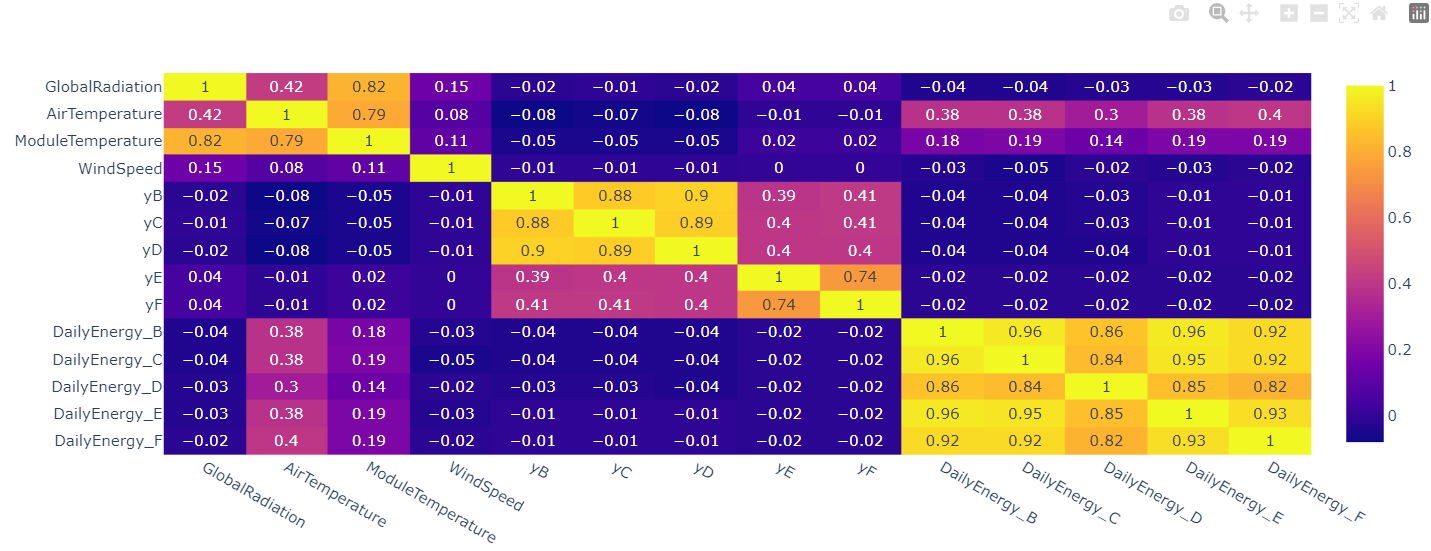

# Manualy Anomaly Detection and Visualization

Point Anomaly:<br>
A point anomaly is defined as a single data point that is unusual compared to the rest of the data. A single balmy day in an otherwise chilly winter would be a good example of this.
On that day, the weather is considered anomalous because the temperature is extreme compared to the rest of the season. Point anomalies often occur in this way, as a singular extreme value on a single attribute of the data.

Contextual Anomaly:<br>
Also called conditional outliers, contextual anomalies contain data points that significantly deviate from the other data points that exist in the same context. An anomaly in the context of one dataset may not be an anomaly in another.
For instance, one of your customers may double their usual spending behavior in mid-December for the holiday season. These outliers are common in time series data because those datasets are records of specific quantities for given periods.

Collective anomaly:<br>
A collective anomaly is a collection of similar data points that can be considered abnormal together when compared to the rest of the data.
For example, a consecutive 10-day period of hot temperatures could be considered a collective anomaly.
These temperatures are unusual because they occur together and are likely caused by the same underlying weather event.

## Point Anomaly

### Daily Energy

The Daily Energy variable is designed to exhibit a consistent daily growth pattern. It starts with an initial value of 0 and experiences continuous minute-by-minute energy generation throughout the day, reaching its peak before resetting to 0 at the day's end. A visual representation of this behavior in the plot highlights an anomaly in the data, particularly during the midday period. During this timeframe, the data logger records values of Daily Energy (t) that are lower than the preceding timestamp (t-1), suggesting a potential anomaly stemming from either the data logger itself or the underlying database.

In [221]:
df_periodo = df[(df.index >= '2022-05-12') & (df.index < '2022-05-16')]
plt.plot(x = df_periodo.index,y= [df_periodo['DailyEnergy_B'],df_periodo['DailyEnergy_C'],df_periodo['DailyEnergy_D'],df_periodo['DailyEnergy_F']], data_frame=df_periodo, kind='line')

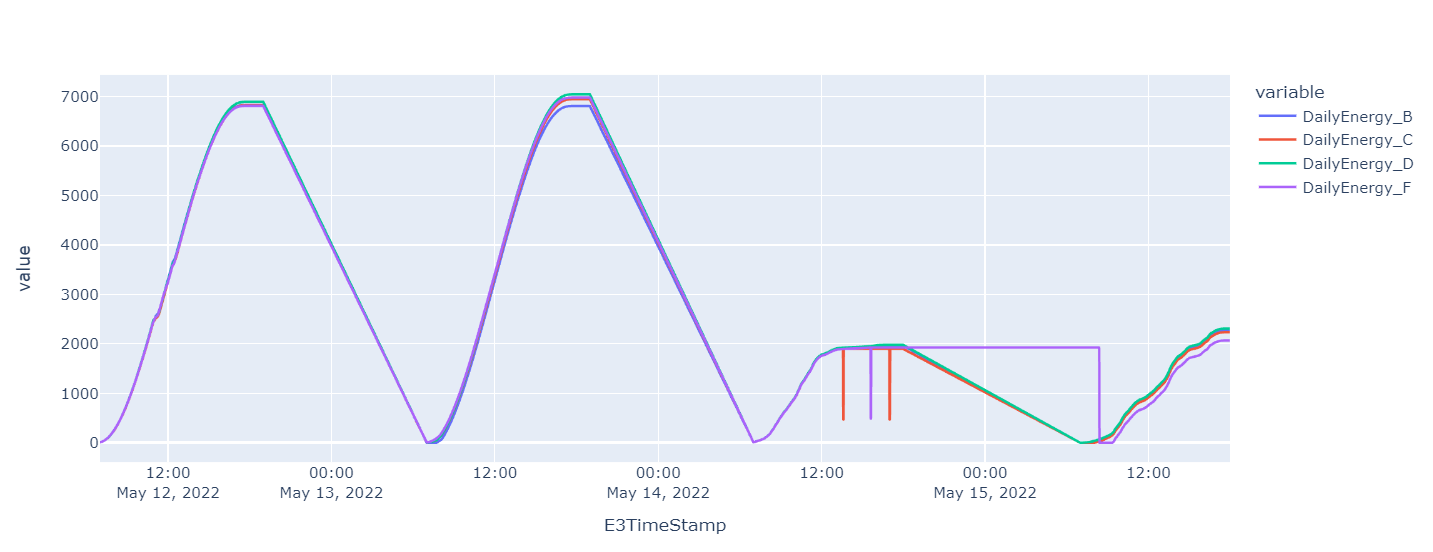

### yX
The variable yX is derived from the daily energy measurement, representing the energy production per minute. Within the time series, we can identify point anomalies, with instances where the values turn negative serving as indicators of potential issues in the data logger associated with the Daily Energy information.

In [220]:
df_periodo = df[(df.index >= '2022-05-12') & (df.index < '2022-05-16')]
plt.plot(x = df_periodo.index,y= [df_periodo['yB'],df_periodo['yC'],df_periodo['yD'],df_periodo['yF']], data_frame=df_periodo, kind='line')

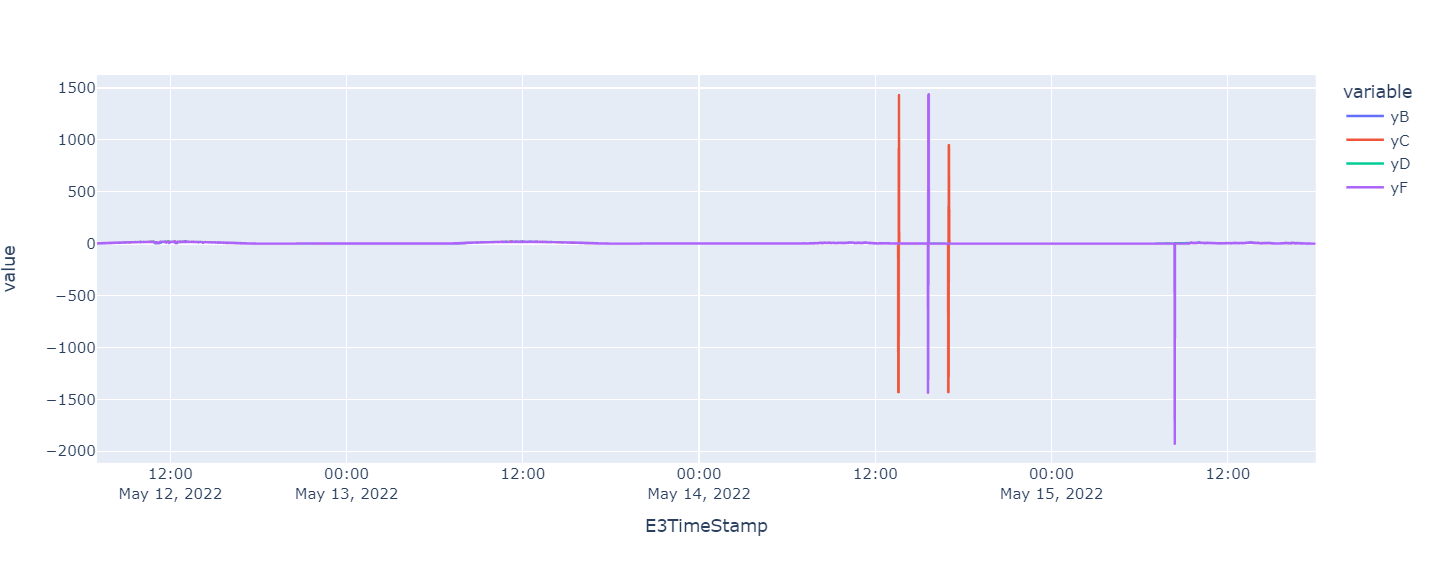

### Global Radiation
Examine anomalies in global radiation, particularly sudden drops throughout the day and isolated zero values. These significant variations may indicate potential issues in the measurement system or data acquisition, necessitating a more in-depth investigation to ensure the accuracy and reliability of global radiation information.

In [219]:
df_periodo = df[(df.index >= '2022-08-09') & (df.index < '2022-08-18')]
plt.plot(x = df_periodo.index,y= [df_periodo['GlobalRadiation']], data_frame=df_periodo, kind='line')

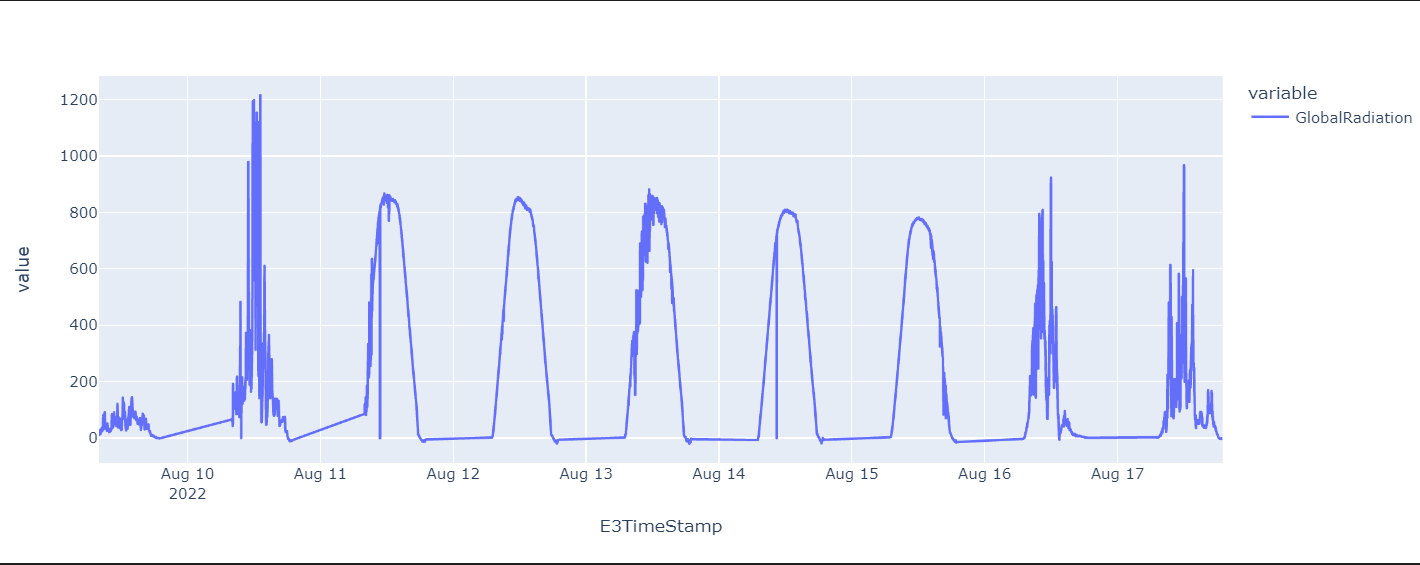

## Collective Anomaly

### Air Temperature and Module Temperature
Examine anomalous readings in the air temperature and tempModulo data logger, specifically focusing on maximum temperatures reaching 195 degrees observed in the EDA section. Notably, there are extremely high temperatures recorded during nighttime periods, suggesting potential anomalies that warrant investigation.

In [99]:
df[df.AirTemperature > 50.0]

,ActivePowerTotal,TotalEnergy_DataLogger,DailyEnergy_DataLogger,GlobalRadiation,AirTemperature,ModuleTemperature,WindSpeed,TotalEnergy_B,DailyEnergy_B,ReactiveEnergy_B,...,DailyEnergy_E,ReactiveEnergy_E,TotalEnergy_F,DailyEnergy_F,ReactiveEnergy_F,yB,yC,yD,yE,yF
E3TimeStamp,,,,,,,,,,,,,,,,,,,,,
2022-05-18 14:44:48.840,3452.0,6631063.0,10552.0,308.0,54.0,67.0,-10.0,1925344.1,2585.4,-6.751,...,2618.2,-4.561,947117.3,2619.6,-4.951,7.5,6.5,0.0,7.7,9.1
2022-05-18 14:46:48.763,2319.0,6631114.0,10603.0,428.0,60.0,73.0,-10.0,1925356.3,2597.4,-0.503,...,2630.7,0.624,947132.8,2634.9,-1.396,9.0,8.1,0.0,7.7,7.1
2022-05-18 14:47:48.780,1078.0,6631146.0,10635.0,160.0,62.0,75.0,-10.0,1925365.3,2606.4,-1.382,...,2638.4,-1.179,947139.9,2642.0,-1.187,5.8,6.7,0.0,8.3,9.1
2022-05-18 14:48:48.773,3278.0,6631176.0,10665.0,465.0,74.0,87.0,-10.0,1925371.2,2612.2,-4.231,...,2646.7,-5.718,947148.9,2651.1,-3.788,14.2,14.2,0.0,15.1,15.8
2022-05-18 14:49:48.750,3741.0,6631235.0,10724.0,621.0,70.0,83.0,-10.0,1925384.7,2626.4,9.090,...,2661.8,9.314,947164.7,2666.9,10.176,10.8,11.5,0.0,13.9,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-19 11:15:48.753,2030.0,6642257.0,7720.0,252.0,91.0,102.0,-10.0,1927639.7,1519.2,5.257,...,1603.0,5.279,949542.0,1631.2,5.270,6.8,7.1,7.2,6.9,7.0
2022-05-19 11:16:48.757,2199.0,6642292.0,7755.0,274.0,91.0,103.0,-10.0,1927646.4,1526.0,6.616,...,1609.9,7.057,949548.9,1638.2,7.121,7.2,7.1,7.7,7.8,7.8
2022-05-19 11:28:48.847,2265.0,6642782.0,8245.0,277.0,54.0,69.0,-10.0,1927745.3,1624.9,5.308,...,1708.1,4.330,949648.8,1738.0,4.187,8.7,8.5,7.0,7.1,6.8


In [218]:
df_periodo = df[(df.index >= '2022-05-18') & (df.index < '2022-05-22')]
plt.plot(x = df_periodo.index,y= [df_periodo['AirTemperature'],df_periodo['ModuleTemperature']], data_frame=df_periodo, kind='line')

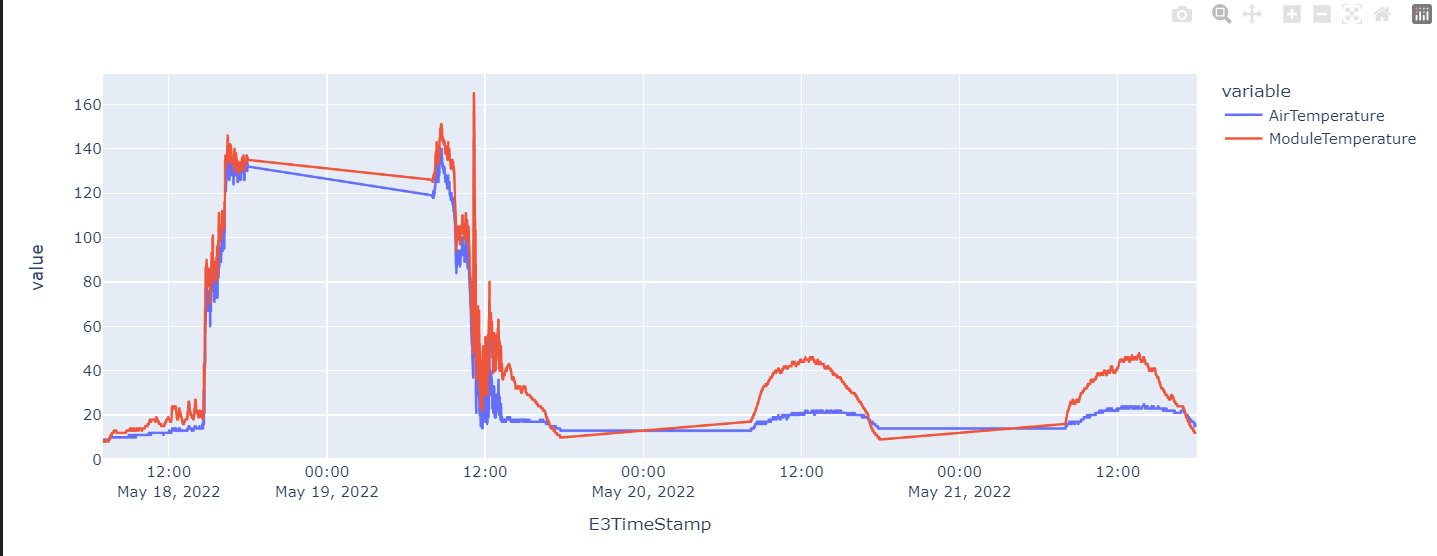

### Wind Speed
Anomalies in wind speed readings, especially when they remain consistently at -10, can be indicative of measurement errors, instrument malfunction, or data transmission issues. Wind speed is typically measured in positive values, and sustained negative readings are not physically meaningful in the context of standard wind speed measurements.

In [101]:
df[df.WindSpeed < 0]

,ActivePowerTotal,TotalEnergy_DataLogger,DailyEnergy_DataLogger,GlobalRadiation,AirTemperature,ModuleTemperature,WindSpeed,TotalEnergy_B,DailyEnergy_B,ReactiveEnergy_B,...,DailyEnergy_E,ReactiveEnergy_E,TotalEnergy_F,DailyEnergy_F,ReactiveEnergy_F,yB,yC,yD,yE,yF
E3TimeStamp,,,,,,,,,,,,,,,,,,,,,
2022-03-22 10:59:55.207,3909.0,4416209.0,10655.0,871.0,28.0,46.0,-10.0,1613070.1,2672.3,7.435,...,2662.4,6.417,648579.3,2676.0,7.426,15.9,16.2,0.0,16.4,16.6
2022-03-22 11:00:55.303,4032.0,4416274.0,10720.0,893.0,28.0,46.0,-10.0,1613085.5,2688.2,7.695,...,2678.8,9.381,648596.0,2692.6,7.971,17.3,15.6,0.0,16.9,16.6
2022-03-22 11:01:55.207,4032.0,4416341.0,10786.0,940.0,28.0,46.0,-10.0,1613103.7,2705.5,8.952,...,2695.7,8.680,648612.7,2709.2,8.994,16.4,17.5,0.0,16.9,17.0
2022-03-22 11:02:55.177,4032.0,4416409.0,10854.0,1062.0,28.0,46.0,-10.0,1613119.9,2721.9,2.078,...,2712.6,2.329,648629.7,2726.2,-2.449,16.6,16.6,0.0,16.7,16.8
2022-03-22 11:03:55.187,4032.0,4416476.0,10921.0,1056.0,28.0,46.0,-10.0,1613136.2,2738.5,-4.827,...,2729.3,-4.730,648646.5,2743.0,-4.559,16.3,16.5,0.0,16.9,16.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-26 14:51:48.810,3308.0,6882336.0,22009.0,511.0,28.0,39.0,-10.0,1975152.8,4375.5,5.748,...,4419.6,6.017,997714.2,4414.1,5.910,10.0,9.5,9.5,9.4,9.5
2022-05-26 14:52:48.950,2504.0,6882384.0,22057.0,396.0,28.0,39.0,-10.0,1975162.7,4385.5,-3.950,...,4429.0,-3.452,997723.7,4423.6,-3.476,6.1,7.2,7.3,7.2,7.1
2022-05-26 14:53:48.850,1988.0,6882420.0,22092.0,325.0,28.0,39.0,-10.0,1975169.3,4391.6,-0.722,...,4436.2,-0.522,997730.8,4430.7,-0.348,7.4,5.3,7.1,7.3,7.3


In [217]:
df_periodo = df[(df.index >= '2022-03-21') & (df.index < '2022-03-25')]
plt.plot(x = df_periodo.index,y= [df_periodo['WindSpeed']], data_frame=df_periodo, kind='line')

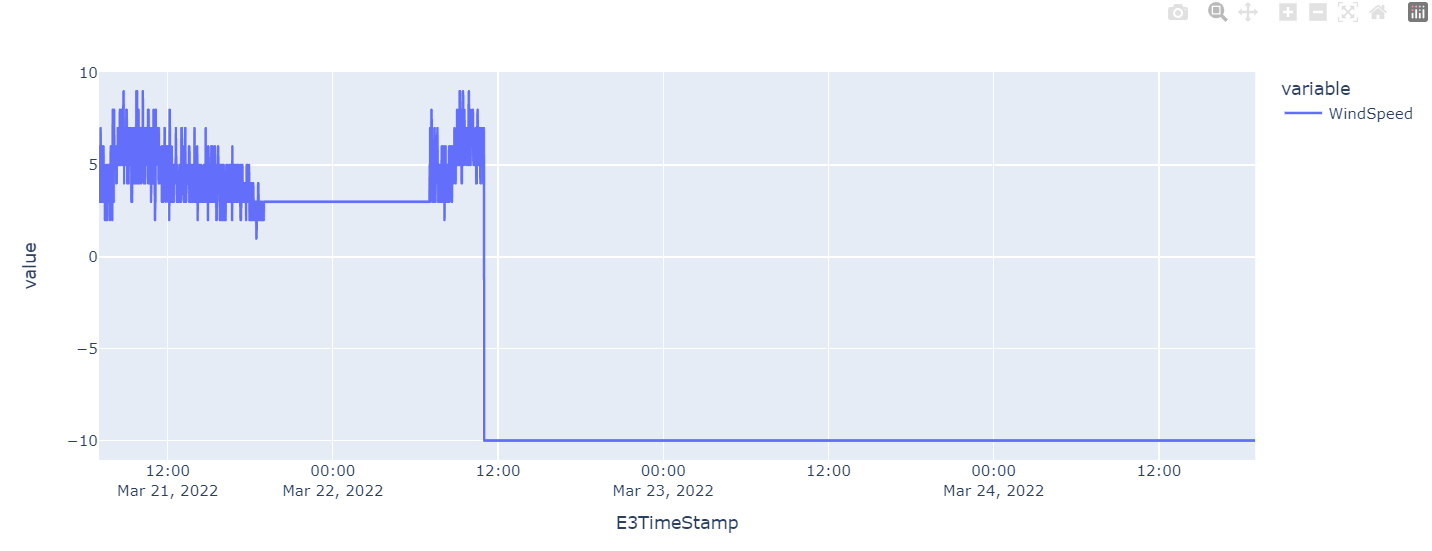

# Label Data

## Daily Energy

To label Daily Energy we are going to label every value that is not in continuous growth as a anomaly analyzing each day. <br>
for day x: if t > t-1 & t > t-2 & t > t-3: anomaly = True

In [214]:
daily_energy_list = ['DailyEnergy_B','DailyEnergy_C','DailyEnergy_D','DailyEnergy_E','DailyEnergy_F']
df['YMD'] = df.reset_index().E3TimeStamp.dt.strftime('%Y%m%d').values
for column in daily_energy_list:
    for day in set(df['YMD']):
        df_day = df[df['YMD'] == day]
        data_series = pd.Series(df_day[column])
        continuous_value = data_series[(data_series.gt(data_series.shift(1)))&(data_series.gt(data_series.shift(2)))&(data_series.gt(data_series.shift(3)))]
        non_continuous_value = data_series[~((data_series.gt(data_series.shift(1)))&(data_series.gt(data_series.shift(2)))&(data_series.gt(data_series.shift(3))))]
        df.loc[non_continuous_value.index,str(column)+'_is_anomaly'] = True
        df.loc[continuous_value.index,str(column)+'_is_anomaly'] = False

In [216]:
import plotly.express as px

# Filter True values
df_true = df[(df.index >= '2022-05-12') & (df.index < '2022-05-16') & (df['DailyEnergy_C_is_anomaly'] == True)]

# Filter False values
df_false = df[(df.index >= '2022-05-12') & (df.index < '2022-05-16') & (df['DailyEnergy_C_is_anomaly'] == False)]

# Create a scatter plot with different colors for True and False
fig = px.scatter()
fig.add_trace(px.scatter(df_true, x=df_true.index, y='DailyEnergy_C', color_discrete_sequence=['blue'], labels='Anomaly').data[0])
fig.add_trace(px.scatter(df_false, x=df_false.index, y='DailyEnergy_C', color_discrete_sequence=['red'], labels='Normal Behavior').data[0])

# Show the plot
fig.show()


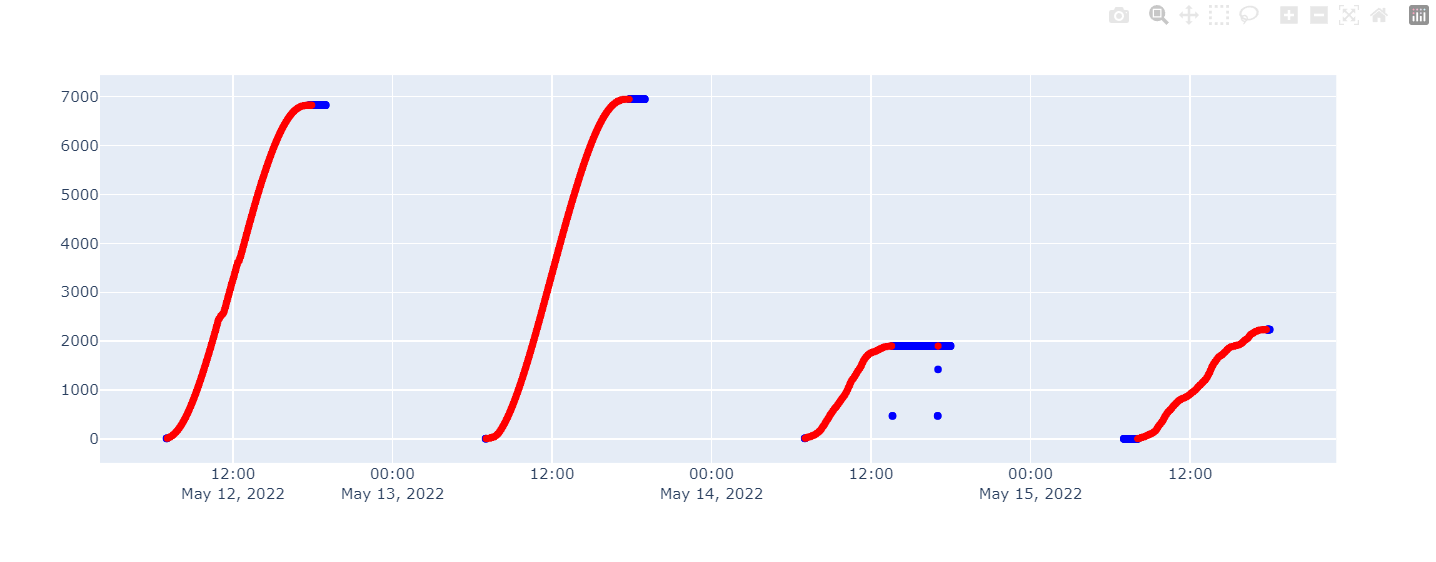

# Anomaly detection

## PYOD Unsupervised Outlier Detection Using Empirical Cumulative Distribution Functions <br>

In [183]:
start_time = time.time()

df_anomaly = df[['yB', 'yC', 'yD', 'yE', 'yF','VelocidadeVento','TempModulo','TempAr','RadiacaoGlobal']].copy()

train_row_number = 80000

for y in df_anomaly.columns:
    df_y = df_anomaly[[y]]

    # Normalize and save the mean and std we get,
    # for normalizing test data.
    training_mean = df_y.mean()
    training_std = df_y.std()
    df_y_normalized = (df_y - training_mean) / training_std

    train = df_y_normalized.iloc[:train_row_number,:]
    test = df_y_normalized.iloc[train_row_number:,:]

    clf = ECOD()
    clf.fit(train)

    # get outlier scores
    y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
    y_test_scores = clf.decision_function(test)  # predict raw outlier scores on test

    # The threshold is 6 times the standard deviation
    results_ecod_test = df_y[[y]].iloc[train_row_number:,:][(y_test_scores > y_test_scores.std()*6)]
    results_ecod_training = df_y[[y]].iloc[:train_row_number,:][(y_train_scores > y_train_scores.std()*6)]

    total_anomalias = df_anomaly.loc[pd.concat([results_ecod_test,results_ecod_training]).index,:]

    df_y.loc[total_anomalias.index,:] = None
    df_anomaly[str(y) + '_anomalia'] = False
    df_anomaly.loc[total_anomalias.index,str(y) + '_anomalia'] = True

    df_anomaly[y] = df_y[y].interpolate()

end_time = time.time()

# Resultado ECOD:
ecod_results = pd.DataFrame(df_anomaly[['yB_anomalia', 'yC_anomalia', 'yD_anomalia',
   'yE_anomalia', 'yF_anomalia', 'VelocidadeVento_anomalia',
   'TempModulo_anomalia', 'TempAr_anomalia',
   'RadiacaoGlobal_anomalia']].sum()/len(df_anomaly) * 100, columns = ["% of anomaly"])
ecod_results.loc['algoritmo_anomalia',:] = 'PyOD - ECOD'
ecod_results.loc['tempo_execucao (s)',:] = end_time - start_time
ecod_results.loc['threshold',:] = "6x scores std"
ecod_results.loc['% of traning samples',:] = len(train)/len(df_anomaly)*100

## Resultado ECOD
- % Anomalia<br>
- Verificação dos valores máximos e mínimos
- Correlação entre variáveis
- Threshold utilizado

In [185]:
ecod_results

,% of anomaly
yB_anomalia,0.525776
yC_anomalia,0.509087
yD_anomalia,0.473379
yE_anomalia,0.546864
yF_anomalia,0.504688
VelocidadeVento_anomalia,0.475449
TempModulo_anomalia,0.250339
TempAr_anomalia,0.251891
RadiacaoGlobal_anomalia,0.59111
algoritmo_anomalia,PyOD - ECOD


In [72]:
try:
  df = df.set_index('E3TimeStamp')
except:
  pass


df_filtered = df_anomaly[['RadiacaoGlobal', 'TempAr', 'TempModulo',
       'VelocidadeVento', 'yB', 'yC', 'yD', 'yE', 'yF']]

df_descricao = pd.DataFrame()

df_descricao['No_None_Values_Count'] = round(df_filtered.apply(lambda x: x.count()),2)
df_descricao['None_Values_Count'] = round(df_filtered.apply(lambda x: x.isnull().sum()),2)
df_descricao['Zeroes_Values_Count'] = round(df_filtered.apply(lambda x: (x == 0).sum()),2)
df_descricao['Min_Values'] = round(df_filtered.apply(lambda x: x.min()),2)
df_descricao['Max_Values'] = round(df_filtered.apply(lambda x: x.max()),2)
df_descricao['Mean_Values'] = round(df_filtered.apply(lambda x: x.mean()),2)
df_descricao['Std_Values'] = round(df_filtered.apply(lambda x: x.std()),2)
df_descricao['Sum of Values'] = round(df_filtered.apply(lambda x: x.sum()),0)
df_descricao['Min_Date'] = df_filtered.index.min()
df_descricao['Max_Date'] = df_filtered.index.max()
df_descricao

,No_None_Values_Count,None_Values_Count,Zeroes_Values_Count,Min_Values,Max_Values,Mean_Values,Std_Values,Sum of Values,Min_Date,Max_Date
RadiacaoGlobal,772953,0,33797,-13.0,1324.0,214.70,318.62,165952794.0,2021-12-09 10:36:17.677,2023-08-09 22:19:10.373
TempAr,772953,0,6502,0.0,39.0,23.38,5.88,18073734.0,2021-12-09 10:36:17.677,2023-08-09 22:19:10.373
TempModulo,772953,0,6517,0.0,69.0,27.63,13.67,21357582.0,2021-12-09 10:36:17.677,2023-08-09 22:19:10.373
VelocidadeVento,772953,0,145683,-10.0,6.0,0.48,4.14,374234.0,2021-12-09 10:36:17.677,2023-08-09 22:19:10.373
yB,772953,0,429956,0.0,26.1,3.84,5.78,2971977.0,2021-12-09 10:36:17.677,2023-08-09 22:19:10.373
yC,772953,0,436247,0.0,34.6,3.74,5.70,2889621.0,2021-12-09 10:36:17.677,2023-08-09 22:19:10.373
yD,772953,0,448630,0.0,18.6,3.53,5.58,2730929.0,2021-12-09 10:36:17.677,2023-08-09 22:19:10.373
yE,772953,0,429668,0.0,17.2,3.79,5.71,2927693.0,2021-12-09 10:36:17.677,2023-08-09 22:19:10.373
yF,772953,0,423469,0.0,17.2,3.88,5.79,2997650.0,2021-12-09 10:36:17.677,2023-08-09 22:19:10.373


In [86]:
df_corr = df_filtered.corr()

fig = px.imshow(df_corr, text_auto=True, aspect="auto")
fig.show()

# Criar granularidade de HORA

In [93]:
df_hora_soma = df_filtered[['yB','yC', 'yD', 'yE', 'yF']]
df_hora_soma = df_hora_soma.resample('H').sum()
df_hora_soma

,yB,yC,yD,yE,yF
E3TimeStamp,,,,,
2021-12-09 10:00:00,0.000000,0.000000,0.000000,0.0,0.0
2021-12-09 11:00:00,496.200000,486.650000,395.000000,0.0,0.0
2021-12-09 12:00:00,70.000000,71.800000,71.000000,0.0,0.0
2021-12-09 13:00:00,19.000000,86.000000,89.000000,0.0,0.0
2021-12-09 14:00:00,1433.030928,1540.227835,1601.291753,0.0,0.0
...,...,...,...,...,...
2023-08-09 18:00:00,2.100000,2.200000,2.300000,2.2,2.4
2023-08-09 19:00:00,0.000000,0.000000,0.000000,0.0,0.0
2023-08-09 20:00:00,0.000000,0.000000,0.000000,0.0,0.0


In [127]:
df_hora_media = df_filtered[['RadiacaoGlobal','TempAr', 'TempModulo','VelocidadeVento']]
df_hora_media = df_hora_media.resample('H').mean()
df_hora_media = df_hora_media.fillna(0)

In [128]:
df_hora = pd.concat([df_hora_soma,df_hora_media], axis = 1)
df_hora

,yB,yC,yD,yE,yF,RadiacaoGlobal,TempAr,TempModulo,VelocidadeVento
E3TimeStamp,,,,,,,,,
2021-12-09 10:00:00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2021-12-09 11:00:00,496.200000,486.650000,395.000000,0.0,0.0,237.593750,6.239583,13.682292,0.406250
2021-12-09 12:00:00,70.000000,71.800000,71.000000,0.0,0.0,441.411392,11.468354,25.405063,0.949367
2021-12-09 13:00:00,19.000000,86.000000,89.000000,0.0,0.0,474.673913,13.862319,21.539855,0.905797
2021-12-09 14:00:00,1433.030928,1540.227835,1601.291753,0.0,0.0,492.442478,16.805310,32.309735,1.274336
...,...,...,...,...,...,...,...,...,...
2023-08-09 18:00:00,2.100000,2.200000,2.300000,2.2,2.4,-1.833333,24.383333,22.200000,0.666667
2023-08-09 19:00:00,0.000000,0.000000,0.000000,0.0,0.0,-7.033333,22.566667,19.750000,0.483333
2023-08-09 20:00:00,0.000000,0.000000,0.000000,0.0,0.0,-4.483333,21.100000,18.066667,0.400000


In [130]:
df_corr = df_hora.corr()

fig = px.imshow(df_corr, text_auto=True, aspect="auto")
fig.show()

## Analise resultados com correlação e tabela de valores min, max, etc

In [129]:
try:
  df_hora = df_hora.set_index('E3TimeStamp')
except:
  pass

df_descricao = pd.DataFrame()

df_descricao['No_None_Values_Count'] = round(df_hora.apply(lambda x: x.count()),2)
df_descricao['None_Values_Count'] = round(df_hora.apply(lambda x: x.isnull().sum()),2)
df_descricao['Zeroes_Values_Count'] = round(df_hora.apply(lambda x: (x == 0).sum()),2)
df_descricao['Min_Values'] = round(df_hora.apply(lambda x: x.min()),2)
df_descricao['Max_Values'] = round(df_hora.apply(lambda x: x.max()),2)
df_descricao['Mean_Values'] = round(df_hora.apply(lambda x: x.mean()),2)
df_descricao['Std_Values'] = round(df_hora.apply(lambda x: x.std()),2)
df_descricao['Sum of Values'] = round(df_hora.apply(lambda x: x.sum()),0)
df_descricao['Min_Date'] = df_hora.index.min()
df_descricao['Max_Date'] = df_hora.index.max()
df_descricao

,No_None_Values_Count,None_Values_Count,Zeroes_Values_Count,Min_Values,Max_Values,Mean_Values,Std_Values,Sum of Values,Min_Date,Max_Date
yB,14605,0,8130,0.00,1433.03,203.49,322.09,2971977.0,2021-12-09 10:00:00,2023-08-09 22:00:00
yC,14605,0,8200,0.00,1540.23,197.85,317.00,2889621.0,2021-12-09 10:00:00,2023-08-09 22:00:00
yD,14605,0,8510,0.00,1601.29,186.99,311.82,2730929.0,2021-12-09 10:00:00,2023-08-09 22:00:00
yE,14605,0,8080,0.00,1008.10,200.46,318.80,2927693.0,2021-12-09 10:00:00,2023-08-09 22:00:00
yF,14605,0,8063,0.00,1008.20,205.25,324.06,2997650.0,2021-12-09 10:00:00,2023-08-09 22:00:00
RadiacaoGlobal,14605,0,1826,-11.14,1189.65,189.60,294.84,2769102.0,2021-12-09 10:00:00,2023-08-09 22:00:00
TempAr,14605,0,1806,0.00,38.78,20.65,9.30,301521.0,2021-12-09 10:00:00,2023-08-09 22:00:00
TempModulo,14605,0,1806,0.00,68.37,24.40,15.47,356310.0,2021-12-09 10:00:00,2023-08-09 22:00:00
VelocidadeVento,14605,0,1971,-10.00,5.51,0.43,3.84,6252.0,2021-12-09 10:00:00,2023-08-09 22:00:00
